#  PREDICTING LOAN DEFAULT

The banking industry has invested significantly in tools to improve banks' ability to predict loan default from observable (and legal) characteristics. The **objective** of this notebook is to develop a supervised learning model to predict loan default.


# 1. Load Data 

We will use the Berka Dataset which is a collection of real anonymized financial information from a Czech bank. 

* `account.asc` (4,500 observations) — each record describes static characteristics of an account.
* `client.asc` (5,369 observations) — each record describes characteristics of a client.
* `disp.asc` (5,369 observations) — each record relates a client with an account.
* `order.asc` (6,471 observations) — each record describes characteristics of credit card payment order.
* `transaction.asc` (1,056,320 observations) — each record describes a transaction for a given account.
* `loan.asc` (682 observations) — each record describes a loan granted for a given account.
* `card.asc` (892 observations) — each record describes a credit card issued to an account.
* `district.asc` (77 observations) — each record describes demographic characteristics of a district.

There is a lot of data here and we'll only use some of it. 
The following image documents how the files connect:

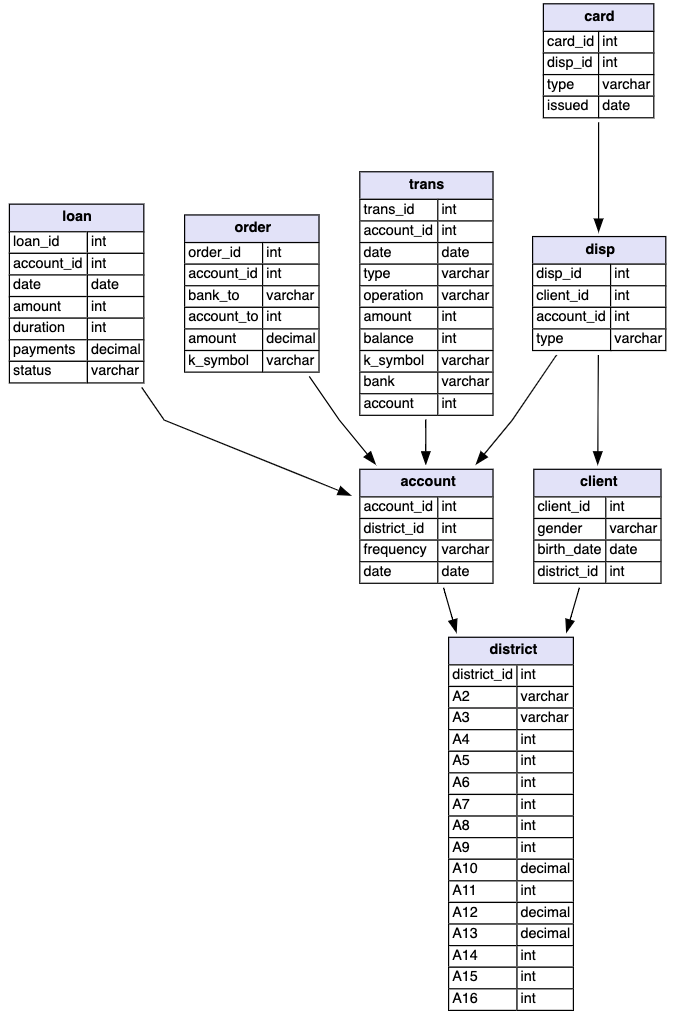

In [155]:
import pandas as pd                       
import numpy as np


from pandas_datareader import data, wb
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [156]:
account = pd.read_csv ('Data/bank_data/account.asc', sep = ';')
card = pd.read_csv ('Data/bank_data/card.asc', sep = ';')
client = pd.read_csv ('Data/bank_data/client.asc', sep = ';')
dispos = pd.read_csv ('Data/bank_data/disp.asc', sep = ';')
district = pd.read_csv ('Data/bank_data/district.asc', sep = ';')
loan = pd.read_csv ('Data/bank_data/loan.asc', sep = ';')
order = pd.read_csv ('Data/bank_data/order.asc', sep = ';')
trans = pd.read_csv ('Data/bank_data/trans.asc', sep = ';')

/var/folders/81/qr8r7f2j2klcf99v0h6rr3880000gn/T/ipykernel_6500/447747106.py:8: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  trans = pd.read_csv ('Data/bank_data/trans.asc', sep = ';')


# 2. Data Pre-processing and Feature Generation 

Let's assemble our main DataFrame and create some additional variables. Initially, we will not incorporate all of the data but you will be free to do so.

## 2.1 Initialize the main dataframe:
* Start with `loan`
* Merge with `account` using variable `account_id`
* Merge new df with `district` using `district_id`

In [157]:
df = loan.merge(account, on = 'account_id', how = 'left')
df.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  
0           30    POPLATEK TYDNE  930322  
1           46  POPLATEK MESICNE  930213  
2           45  POPLATEK MESICNE  930208  
3           12  POPLATEK MESICNE  930130  
4            1    POPLATEK TYDNE  930214

In [158]:
district = district.rename(columns = {'A1' : 'district_id'})
district.head()

district_id           A2               A3       A4  A5  A6  A7  A8  A9  \
0            1  Hl.m. Praha           Prague  1204953   0   0   0   1   1   
1            2      Benesov  central Bohemia    88884  80  26   6   2   5   
2            3       Beroun  central Bohemia    75232  55  26   4   1   5   
3            4       Kladno  central Bohemia   149893  63  29   6   2   6   
4            5        Kolin  central Bohemia    95616  65  30   4   1   6   

     A10    A11   A12   A13  A14    A15    A16  
0  100.0  12541  0.29  0.43  167  85677  99107  
1   46.7   8507  1.67  1.85  132   2159   2674  
2   41.7   8980  1.95  2.21  111   2824   2813  
3   67.4   9753  4.64  5.05  109   5244   5892  
4   51.4   9307  3.85  4.43  118   2616   3040

In [159]:
df1 = df.merge(district, on = 'district_id', how = 'left')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ... A7 A8  A9    A10    A11   A12  \
0           30    POPLATEK TYDNE  930322  ...  8  2  10   81.8   9650  3.38   
1           46  POPLATEK MESICNE  930213  ...  7  3  10   73.5   8369  1.79   
2           45  POPLATEK MESICNE  930208  ...  6  1   5   53.5   8390  2.28   
3           12  POPLATEK MESICNE  930130  ...  6  1   6   58.0   8754  3.83   
4            1    POPLATEK TYDNE  930214  ...  0  1   1  100.0  12541  0.29   

    A13  A14    A15    A16  
0  3.67  100   2985   2804  
1  2.31  117   2854   2618  
2  2.89  132   2080   2122  
3  4.31  137   3804   3868  
4  0.43  167  85677  99107  

[5 rows x 25 columns]

Clean the data:

* Convert dates to datetime
* Date in `account` is date of account creation. Date in `loan` is date loan is issued. Create a variable for days between account creation and loan issuance.
* Change variable "A4" to "Number of Inhabitants"
* Change variable "A11" to "Average Salary"
* Change variable 'A14' to "entrepreneuer rate"
* Create average unemployment rate by averaging "A12" and "A13"
* Create average crime rate by averaging "A15" and "A16" and then dividing by "Number of Inhabitants"

In [160]:
#Changing date to datetime
import datetime
df1['date_loan'] = pd.to_datetime(df1['date_x'], format='%y%m%d')
df1['date_acc'] = pd.to_datetime(df1['date_y'], format='%y%m%d')

#days between account creation and loan issuance
df1['days_between'] = df1['date_loan'] - df1['date_acc']
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ...    A10    A11   A12   A13  A14  \
0           30    POPLATEK TYDNE  930322  ...   81.8   9650  3.38  3.67  100   
1           46  POPLATEK MESICNE  930213  ...   73.5   8369  1.79  2.31  117   
2           45  POPLATEK MESICNE  930208  ...   53.5   8390  2.28  2.89  132   
3           12  POPLATEK MESICNE  930130  ...   58.0   8754  3.83  4.31  137   
4            1    POPLATEK TYDNE  930214  ...  100.0  12541  0.29  0.43  167   

     A15    A16  date_loan   date_acc  days_between  
0   2985   2804 1993-07-05 1993-03-22      105 days  
1   2854   2618 1993-07-11 1993-02-13      148 days  
2   2080   2122 1993-07-28 1993-02-08      170 days  
3   3804   3868 1993-08-03 1993-01-30      185 days  
4  85677  99107 1993-09-06 1993-02-14      204 days  

[5 rows x 28 columns]

In [161]:
#Changing variable names "A4" to "Number of Inhabitants", "A11" to "Average Salary", 'A14' to "entrepreneuer rate

df1 = df1.rename(columns = {'A4' : 'Number of Inhabitants', 'A11' : 'Average Salary', 
                            'A14' : 'Entrepreneuer Rate'})

In [162]:
#generate variable average unemployment rate by averaging "A12" and "A13"

df1['Average Unemployment Rate'] = df1[['A12', 'A13']].mean(axis=1)

/var/folders/81/qr8r7f2j2klcf99v0h6rr3880000gn/T/ipykernel_6500/1926897185.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['Average Unemployment Rate'] = df1[['A12', 'A13']].mean(axis=1)


In [163]:
#Create average crime rate by averaging "A15" and "A16" and then dividing by "Number of Inhabitants"

df1['Average Crime Rate'] = df1[['A15', 'A16']].mean(axis=1)/df1['Number of Inhabitants']
df1.head()

/var/folders/81/qr8r7f2j2klcf99v0h6rr3880000gn/T/ipykernel_6500/1021369474.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df1['Average Crime Rate'] = df1[['A15', 'A16']].mean(axis=1)/df1['Number of Inhabitants']


loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ...   A12   A13  Entrepreneuer Rate  \
0           30    POPLATEK TYDNE  930322  ...  3.38  3.67                 100   
1           46  POPLATEK MESICNE  930213  ...  1.79  2.31                 117   
2           45  POPLATEK MESICNE  930208  ...  2.28  2.89                 132   
3           12  POPLATEK MESICNE  930130  ...  3.83  4.31                 137   
4            1    POPLATEK TYDNE  930214  ...  0.29  0.43                 167   

     A15    A16  date_loan   date_acc  days_between  \
0   2985   2804 1993-07-05 1993-03-22      105 days   
1   2854   2618 1993-07-11 1993-02-13      148 days   
2   2080   2122 1993-07-28 1993-02-08      170 days   
3   3804   3868 1993-08-03 1993-01-30      185 days   
4  85677  99107 1993-09-06 1993-02-14      204 days   

   Average Unemployment Rate  Average Crime Rate  
0                       3.67            0.029574  
1                       2.31            0.023228  
2                       2.89            0.027234  
3                       4.31            0.035858  
4                       0.43            0.082250  

[5 rows x 30 columns]

## 2.2 Add average order amount from `order`:

* Compute average order amount by `account_id`
* Merge to main df

In [164]:
order.head()

order_id  account_id bank_to  account_to  amount k_symbol
0     29401           1      YZ    87144583  2452.0     SIPO
1     29402           2      ST    89597016  3372.7     UVER
2     29403           2      QR    13943797  7266.0     SIPO
3     29404           3      WX    83084338  1135.0     SIPO
4     29405           3      CD    24485939   327.0

In [165]:
order_df = order.groupby('account_id',as_index = False)['amount'].mean()
order_df = order_df.rename(columns = {'amount' : 'Average Amount'})
order_df.head()

account_id  Average Amount
0           1         2452.00
1           2         5319.35
2           3         1667.00
3           4         1681.50
4           5         2668.00

In [166]:
df1 = df1.merge(order_df, on = 'account_id', how = 'left')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ...   A13 Entrepreneuer Rate    A15  \
0           30    POPLATEK TYDNE  930322  ...  3.67                100   2985   
1           46  POPLATEK MESICNE  930213  ...  2.31                117   2854   
2           45  POPLATEK MESICNE  930208  ...  2.89                132   2080   
3           12  POPLATEK MESICNE  930130  ...  4.31                137   3804   
4            1    POPLATEK TYDNE  930214  ...  0.43                167  85677   

     A16  date_loan   date_acc  days_between  Average Unemployment Rate  \
0   2804 1993-07-05 1993-03-22      105 days                       3.67   
1   2618 1993-07-11 1993-02-13      148 days                       2.31   
2   2122 1993-07-28 1993-02-08      170 days                       2.89   
3   3868 1993-08-03 1993-01-30      185 days                       4.31   
4  99107 1993-09-06 1993-02-14      204 days                       0.43   

   Average Crime Rate  Average Amount  
0            0.029574     8033.200000  
1            0.023228     3288.000000  
2            0.027234     2647.825000  
3            0.035858     4966.350000  
4            0.082250     4944.666667  

[5 rows x 31 columns]

## 2.3 Add number of transactions from `transaction`:

* Compute total number of transactions by `account_id`
* Merge to main df

In [167]:
trans.head()

trans_id  account_id    date    type operation  amount  balance k_symbol  \
0    695247        2378  930101  PRIJEM     VKLAD   700.0    700.0      NaN   
1    171812         576  930101  PRIJEM     VKLAD   900.0    900.0      NaN   
2    207264         704  930101  PRIJEM     VKLAD  1000.0   1000.0      NaN   
3   1117247        3818  930101  PRIJEM     VKLAD   600.0    600.0      NaN   
4    579373        1972  930102  PRIJEM     VKLAD   400.0    400.0      NaN   

  bank  account  
0  NaN      NaN  
1  NaN      NaN  
2  NaN      NaN  
3  NaN      NaN  
4  NaN      NaN

In [168]:
trans_df = trans.groupby('account_id',as_index=False)[['trans_id']].count() 
trans_df = trans_df.rename(columns = {'trans_id' : 'Total Transactions'})
trans_df.head()

account_id  Total Transactions
0           1                 239
1           2                 478
2           3                 117
3           4                 186
4           5                  84

In [169]:
df1 = df1.merge(trans_df, on = 'account_id', how = 'left')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ... Entrepreneuer Rate    A15  \
0           30    POPLATEK TYDNE  930322  ...                100   2985   
1           46  POPLATEK MESICNE  930213  ...                117   2854   
2           45  POPLATEK MESICNE  930208  ...                132   2080   
3           12  POPLATEK MESICNE  930130  ...                137   3804   
4            1    POPLATEK TYDNE  930214  ...                167  85677   

     A16  date_loan   date_acc  days_between  Average Unemployment Rate  \
0   2804 1993-07-05 1993-03-22      105 days                       3.67   
1   2618 1993-07-11 1993-02-13      148 days                       2.31   
2   2122 1993-07-28 1993-02-08      170 days                       2.89   
3   3868 1993-08-03 1993-01-30      185 days                       4.31   
4  99107 1993-09-06 1993-02-14      204 days                       0.43   

   Average Crime Rate  Average Amount  Total Transactions  
0            0.029574     8033.200000                 403  
1            0.023228     3288.000000                 633  
2            0.027234     2647.825000                 605  
3            0.035858     4966.350000                 462  
4            0.082250     4944.666667                 571  

[5 rows x 32 columns]

In [170]:
#Changing frequency to numeric values with dummy variables
df1['Monthly'] = ''
df1['Weekly'] = ''
df1['Monthly'] = [1 if x == 'POPLATEK MESICNE' else 0 for x in df.frequency]
df1['Weekly'] = [1 if x == 'POPLATEK TYDNE' else 0 for x in df.frequency]
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ...    A16  date_loan   date_acc  \
0           30    POPLATEK TYDNE  930322  ...   2804 1993-07-05 1993-03-22   
1           46  POPLATEK MESICNE  930213  ...   2618 1993-07-11 1993-02-13   
2           45  POPLATEK MESICNE  930208  ...   2122 1993-07-28 1993-02-08   
3           12  POPLATEK MESICNE  930130  ...   3868 1993-08-03 1993-01-30   
4            1    POPLATEK TYDNE  930214  ...  99107 1993-09-06 1993-02-14   

   days_between  Average Unemployment Rate  Average Crime Rate  \
0      105 days                       3.67            0.029574   
1      148 days                       2.31            0.023228   
2      170 days                       2.89            0.027234   
3      185 days                       4.31            0.035858   
4      204 days                       0.43            0.082250   

   Average Amount  Total Transactions  Monthly  Weekly  
0     8033.200000                 403        0       1  
1     3288.000000                 633        1       0  
2     2647.825000                 605        1       0  
3     4966.350000                 462        1       0  
4     4944.666667                 571        0       1  

[5 rows x 34 columns]

## 2.4 Add credit card type `card`:

* Link card `type` to account_id using `disp`
* Merge to main df

In [171]:
card.head()

card_id  disp_id     type           issued
0     1005     9285  classic  931107 00:00:00
1      104      588  classic  940119 00:00:00
2      747     4915  classic  940205 00:00:00
3       70      439  classic  940208 00:00:00
4      577     3687  classic  940215 00:00:00

In [172]:
#Changing frequency to numeric values with dummy variables
card['Junior'] = ''
card['Classic'] = ''
card['Junior'] = [1 if x == 'junior' else 0 for x in card.type]
card['Classic'] = [1 if x == 'classic' else 0 for x in card.type]
card.head()

card_id  disp_id     type           issued  Junior  Classic
0     1005     9285  classic  931107 00:00:00       0        1
1      104      588  classic  940119 00:00:00       0        1
2      747     4915  classic  940205 00:00:00       0        1
3       70      439  classic  940208 00:00:00       0        1
4      577     3687  classic  940215 00:00:00       0        1

In [173]:
dispos.head()

disp_id  client_id  account_id       type
0        1          1           1      OWNER
1        2          2           2      OWNER
2        3          3           2  DISPONENT
3        4          4           3      OWNER
4        5          5           3  DISPONENT

In [174]:
card_df = card.merge(dispos, on = 'disp_id', how = 'left')

In [175]:
df1 = df1.merge(card_df, on = 'account_id', how = 'left')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id         frequency  date_y  ... Monthly Weekly  card_id  \
0           30    POPLATEK TYDNE  930322  ...       0      1      NaN   
1           46  POPLATEK MESICNE  930213  ...       1      0      NaN   
2           45  POPLATEK MESICNE  930208  ...       1      0      NaN   
3           12  POPLATEK MESICNE  930130  ...       1      0    352.0   
4            1    POPLATEK TYDNE  930214  ...       0      1   1223.0   

   disp_id   type_x           issued  Junior  Classic  client_id  type_y  
0      NaN      NaN              NaN     NaN      NaN        NaN     NaN  
1      NaN      NaN              NaN     NaN      NaN        NaN     NaN  
2      NaN      NaN              NaN     NaN      NaN        NaN     NaN  
3   2235.0  classic  980911 00:00:00     0.0      1.0     2235.0   OWNER  
4  13231.0   junior  950502 00:00:00     1.0      0.0    13539.0   OWNER  

[5 rows x 42 columns]

## 2.5 Add characteristics of the `owner`:

* Create variable for owner's gender
* Use birth data and loan data to create account owner's age
* Create a a boolean that represents if the owner has the same district information as the account
* Merge df to main df using `account id`

In [176]:
client.head()

client_id  birth_number  district_id
0          1        706213           18
1          2        450204            1
2          3        406009            1
3          4        561201            5
4          5        605703            5

In [177]:
#Create variable for owner's gender
client['digits'] = client['birth_number'].astype(str).str[2:4]
client['digits'] = client['digits'].astype(int)
client['Gender'] = ["1" if (x>50) else "0" for x in client.digits]
client.head()

client_id  birth_number  district_id  digits Gender
0          1        706213           18      62      1
1          2        450204            1       2      0
2          3        406009            1      60      1
3          4        561201            5      12      0
4          5        605703            5      57      1

In [178]:
#Client's birthday
client['birth_number'] = np.where(client['digits'] > 50, 
                    client['birth_number'] - 5000, client['birth_number'])

client['digits_1'] = client['birth_number'].astype(str).str[0:2]
client['digits_1'] = client['digits_1'].astype(int)
client['year'] = np.where(client['digits_1'] > 10, 
                 client['digits_1'] + 1900, client['digits_1'] + 2000)
client.head()

client_id  birth_number  district_id  digits Gender  digits_1  year
0          1        701213           18      62      1        70  1970
1          2        450204            1       2      0        45  1945
2          3        401009            1      60      1        40  1940
3          4        561201            5      12      0        56  1956
4          5        600703            5      57      1        60  1960

In [179]:
client['birthday'] = client['year'].astype(str) + "-" + client['birth_number'].astype(str).str[2:4] + "-" + client['birth_number'].astype(str).str[4:6]
client.head()

client_id  birth_number  district_id  digits Gender  digits_1  year  \
0          1        701213           18      62      1        70  1970   
1          2        450204            1       2      0        45  1945   
2          3        401009            1      60      1        40  1940   
3          4        561201            5      12      0        56  1956   
4          5        600703            5      57      1        60  1960   

     birthday  
0  1970-12-13  
1  1945-02-04  
2  1940-10-09  
3  1956-12-01  
4  1960-07-03

In [180]:
client['birthday'] = pd.to_datetime(client['birthday'], infer_datetime_format=True)
client.head()

client_id  birth_number  district_id  digits Gender  digits_1  year  \
0          1        701213           18      62      1        70  1970   
1          2        450204            1       2      0        45  1945   
2          3        401009            1      60      1        40  1940   
3          4        561201            5      12      0        56  1956   
4          5        600703            5      57      1        60  1960   

    birthday  
0 1970-12-13  
1 1945-02-04  
2 1940-10-09  
3 1956-12-01  
4 1960-07-03

In [181]:
#merge with dispos
dispos_df = client.merge(dispos, on = 'client_id', how = 'left')
dispos_df.head()

client_id  birth_number  district_id  digits Gender  digits_1  year  \
0          1        701213           18      62      1        70  1970   
1          2        450204            1       2      0        45  1945   
2          3        401009            1      60      1        40  1940   
3          4        561201            5      12      0        56  1956   
4          5        600703            5      57      1        60  1960   

    birthday  disp_id  account_id       type  
0 1970-12-13        1           1      OWNER  
1 1945-02-04        2           2      OWNER  
2 1940-10-09        3           2  DISPONENT  
3 1956-12-01        4           3      OWNER  
4 1960-07-03        5           3  DISPONENT

In [182]:
disp_df = dispos_df[(dispos_df.type == 'OWNER')]
disp_df.head()

client_id  birth_number  district_id  digits Gender  digits_1  year  \
0          1        701213           18      62      1        70  1970   
1          2        450204            1       2      0        45  1945   
3          4        561201            5      12      0        56  1956   
5          6        190922           12       9      0        19  1919   
6          7        290125           15       1      0        29  1929   

    birthday  disp_id  account_id   type  
0 1970-12-13        1           1  OWNER  
1 1945-02-04        2           2  OWNER  
3 1956-12-01        4           3  OWNER  
5 1919-09-22        6           4  OWNER  
6 1929-01-25        7           5  OWNER

In [183]:
df1 = df1.merge(dispos_df, on = 'account_id', how = 'left')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id_x         frequency  date_y  ... client_id_y birth_number  \
0             30    POPLATEK TYDNE  930322  ...        2166       470722   
1             46  POPLATEK MESICNE  930213  ...        2181       680722   
2             45  POPLATEK MESICNE  930208  ...       11314       360602   
3             12  POPLATEK MESICNE  930130  ...        2235       400420   
4              1    POPLATEK TYDNE  930214  ...       13539       780907   

   district_id_y  digits  Gender  digits_1  year   birthday  disp_id_y   type  
0             30      57       1        47  1947 1947-07-22       2166  OWNER  
1             46       7       0        68  1968 1968-07-22       2181  OWNER  
2             45       6       0        36  1936 1936-06-02      11006  OWNER  
3             14      54       1        40  1940 1940-04-20       2235  OWNER  
4             63       9       0        78  1978 1978-09-07      13231  OWNER  

[5 rows x 52 columns]

In [184]:
#Finding owner's age
df1['Owners_Age'] = df1['date_loan'] - df1['birthday']
df1['Owners_Age'] = df1['Owners_Age'] / np.timedelta64(1, 'Y')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id_x         frequency  date_y  ... birth_number district_id_y  \
0             30    POPLATEK TYDNE  930322  ...       470722            30   
1             46  POPLATEK MESICNE  930213  ...       680722            46   
2             45  POPLATEK MESICNE  930208  ...       360602            45   
3             12  POPLATEK MESICNE  930130  ...       400420            14   
4              1    POPLATEK TYDNE  930214  ...       780907            63   

   digits  Gender  digits_1  year   birthday  disp_id_y   type  Owners_Age  
0      57       1        47  1947 1947-07-22       2166  OWNER   45.955769  
1       7       0        68  1968 1968-07-22       2181  OWNER   24.969712  
2       6       0        36  1936 1936-06-02      11006  OWNER   57.153809  
3      54       1        40  1940 1940-04-20       2235  OWNER   53.287884  
4       9       0        78  1978 1978-09-07      13231  OWNER   14.998255  

[5 rows x 53 columns]

In [185]:
#Create a a boolean that represents if the owner has the same district information as the account

df1['Same_District'] = np.where(df1['district_id_x'] == df1['district_id_y'], '1', '0')
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id_x         frequency  date_y  ... district_id_y digits  Gender  \
0             30    POPLATEK TYDNE  930322  ...            30     57       1   
1             46  POPLATEK MESICNE  930213  ...            46      7       0   
2             45  POPLATEK MESICNE  930208  ...            45      6       0   
3             12  POPLATEK MESICNE  930130  ...            14     54       1   
4              1    POPLATEK TYDNE  930214  ...            63      9       0   

   digits_1  year   birthday  disp_id_y   type  Owners_Age  Same_District  
0        47  1947 1947-07-22       2166  OWNER   45.955769              1  
1        68  1968 1968-07-22       2181  OWNER   24.969712              1  
2        36  1936 1936-06-02      11006  OWNER   57.153809              1  
3        40  1940 1940-04-20       2235  OWNER   53.287884              0  
4        78  1978 1978-09-07      13231  OWNER   14.998255              0  

[5 rows x 54 columns]

## 2.6 Add loan default status:

The `loan` file contains a status variable which will be helpful:

* "A" Contract finished, no problems.
* "B" Contract finished, loan not repaid.
* "C" Running contract, okay so far.
* "D" Running contract, client in debt.

Define A and C as being in "good" status. Define B and D as being in "Default". Create a new variable called "default" which indicates whether the loan is in good status or not.

In [186]:
#Define A and C as being in "good" status. Define B and D as being in "Default"
df1['Loan'] = ['Good' if (x=='A' or x=='C') else 'Default' for x in df1.status]
df1.head()

loan_id  account_id  date_x  amount  duration  payments status  \
0     5314        1787  930705   96396        12    8033.0      B   
1     5316        1801  930711  165960        36    4610.0      A   
2     6863        9188  930728  127080        60    2118.0      A   
3     5325        1843  930803  105804        36    2939.0      A   
4     7240       11013  930906  274740        60    4579.0      A   

   district_id_x         frequency  date_y  ... digits Gender  digits_1  year  \
0             30    POPLATEK TYDNE  930322  ...     57      1        47  1947   
1             46  POPLATEK MESICNE  930213  ...      7      0        68  1968   
2             45  POPLATEK MESICNE  930208  ...      6      0        36  1936   
3             12  POPLATEK MESICNE  930130  ...     54      1        40  1940   
4              1    POPLATEK TYDNE  930214  ...      9      0        78  1978   

    birthday  disp_id_y   type  Owners_Age  Same_District     Loan  
0 1947-07-22       2166  OWNER   45.955769              1  Default  
1 1968-07-22       2181  OWNER   24.969712              1     Good  
2 1936-06-02      11006  OWNER   57.153809              1     Good  
3 1940-04-20       2235  OWNER   53.287884              0     Good  
4 1978-09-07      13231  OWNER   14.998255              0     Good  

[5 rows x 55 columns]

In [189]:
df2 = df1[['amount', 'duration', 'payments', 'days_between', 'Average Amount', 
           'Total Transactions', "Number of Inhabitants",
          'Average Salary', 'Average Unemployment Rate', 
           'Entrepreneuer Rate', 'Average Crime Rate', 'Gender', 'Owners_Age',
          'Same_District', 'Loan', 'Junior', 'Classic', 'Monthly', 'Weekly' ]]

In [190]:
df3=df2.dropna()
df3.head()

amount  duration  payments days_between  Average Amount  \
3   105804        36    2939.0     185 days     4966.350000   
4   274740        60    4579.0     204 days     4944.666667   
10  117024        24    4876.0     137 days     4875.800000   
40   51696        24    2154.0     396 days     2153.800000   
47  167100        60    2785.0     335 days     2784.800000   

    Total Transactions  Number of Inhabitants  Average Salary  \
3                  462                 107870            8754   
4                  571                1204953           12541   
10                 410                 177686           10045   
40                 500                 323870           10673   
47                 438                 145688            8544   

    Average Unemployment Rate  Entrepreneuer Rate  Average Crime Rate Gender  \
3                        4.31                 137            0.035858      1   
4                        0.43                 167            0.082250      0   
10                       1.71                 135            0.035428      0   
40                       5.44                 100            0.056649      1   
47                       1.86                 109            0.019947      1   

    Owners_Age Same_District  Loan  Junior  Classic  Monthly  Weekly  
3    53.287884             0  Good     0.0      1.0        1       0  
4    14.998255             0  Good     1.0      0.0        0       1  
10   58.090173             1  Good     0.0      1.0        1       0  
40   26.116895             1  Good     0.0      1.0        1       0  
47   24.216787             1  Good     0.0      1.0        1       0

In [191]:
df3['days_between'] = df3['days_between'].dt.days
df3.head()

/var/folders/81/qr8r7f2j2klcf99v0h6rr3880000gn/T/ipykernel_6500/773999668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['days_between'] = df3['days_between'].dt.days


amount  duration  payments  days_between  Average Amount  \
3   105804        36    2939.0           185     4966.350000   
4   274740        60    4579.0           204     4944.666667   
10  117024        24    4876.0           137     4875.800000   
40   51696        24    2154.0           396     2153.800000   
47  167100        60    2785.0           335     2784.800000   

    Total Transactions  Number of Inhabitants  Average Salary  \
3                  462                 107870            8754   
4                  571                1204953           12541   
10                 410                 177686           10045   
40                 500                 323870           10673   
47                 438                 145688            8544   

    Average Unemployment Rate  Entrepreneuer Rate  Average Crime Rate Gender  \
3                        4.31                 137            0.035858      1   
4                        0.43                 167            0.082250      0   
10                       1.71                 135            0.035428      0   
40                       5.44                 100            0.056649      1   
47                       1.86                 109            0.019947      1   

    Owners_Age Same_District  Loan  Junior  Classic  Monthly  Weekly  
3    53.287884             0  Good     0.0      1.0        1       0  
4    14.998255             0  Good     1.0      0.0        0       1  
10   58.090173             1  Good     0.0      1.0        1       0  
40   26.116895             1  Good     0.0      1.0        1       0  
47   24.216787             1  Good     0.0      1.0        1       0

In [192]:
df3.describe()

amount    duration     payments  days_between  Average Amount  \
count     206.000000  206.000000   206.000000    206.000000      206.000000   
mean   160102.543689   35.766990  4574.752427    413.587379     4768.387864   
std    117514.451753   17.618839  2238.274573    165.740348     2183.911057   
min     12540.000000   12.000000   312.000000    110.000000      312.000000   
25%     72549.000000   24.000000  2849.750000    281.000000     3096.840000   
50%    120120.000000   36.000000  4509.000000    410.000000     4624.500000   
75%    222969.000000   48.000000  6466.000000    560.750000     6387.812500   
max    495180.000000   60.000000  9910.000000    689.000000     9794.500000   

       Total Transactions  Number of Inhabitants  Average Salary  \
count          206.000000           2.060000e+02      206.000000   
mean           280.563107           2.617518e+05     9504.752427   
std            133.000104           3.448977e+05     1284.600890   
min             49.000000           4.282100e+04     8173.000000   
25%            176.250000           8.888400e+04     8548.000000   
50%            262.000000           1.252360e+05     8994.000000   
75%            376.000000           2.261220e+05     9897.000000   
max            643.000000           1.204953e+06    12541.000000   

       Average Unemployment Rate  Entrepreneuer Rate  Average Crime Rate  \
count                 206.000000          206.000000          206.000000   
mean                    3.672136          121.466019            0.037585   
std                     2.194278           22.354490            0.019037   
min                     0.430000           81.000000            0.016713   
25%                     1.860000          107.000000            0.022636   
50%                     3.950000          116.500000            0.032871   
75%                     5.390000          132.000000            0.044128   
max                     9.400000          167.000000            0.082250   

       Owners_Age      Junior     Classic     Monthly      Weekly  
count  206.000000  206.000000  206.000000  206.000000  206.000000  
mean    37.779834    0.135922    0.762136    0.859223    0.101942  
std     14.125507    0.343541    0.426813    0.348638    0.303309  
min     12.720316    0.000000    0.000000    0.000000    0.000000  
25%     24.524118    0.000000    1.000000    1.000000    0.000000  
50%     37.473733    0.000000    1.000000    1.000000    0.000000  
75%     51.066073    0.000000    1.000000    1.000000    0.000000  
max     61.775396    1.000000    1.000000    1.000000    1.000000

### <font color=red>Comments</font> 

Your final dataframe should have about 700 observations and include the following variables (your variable names can be different):

| Variable | Description |
|:-|:-|
| amount| Loan amount |
| duration| Loan duration |
| payments| Loan payments |
| days_between| Days between account creation and loan issuance |
| frequency| Frequency of issuance of statements |
| average_order_amount| Average amount of the permanent orders made by the account |
| average_trans_amount| Average amount of the transactions made by the account |
| average_trans_balance| Average balance amount after transactions made by the account |
| n_trans| Transaction number of account |
| card_type| Type of credit card associated with the account |
| n_inhabitants| Number of inhabitants in the district of account |
| average_salary| Average salary in the district of account |
| average_unemployment| Average unemployment rate in the district of account |
| entrepreneur_rate| Number of entrepreneurs per 1000 inhabitants in the district of account |
| average_crime_rate| Average crime rate in the district of account |
| owner_gender| Account owner's gender |
| owner_age| Account owner's age |
| same_district| A boolean that represents if the owner has the same district information as the account |

Below is a picture of the descriptive statistics for my dataframe.
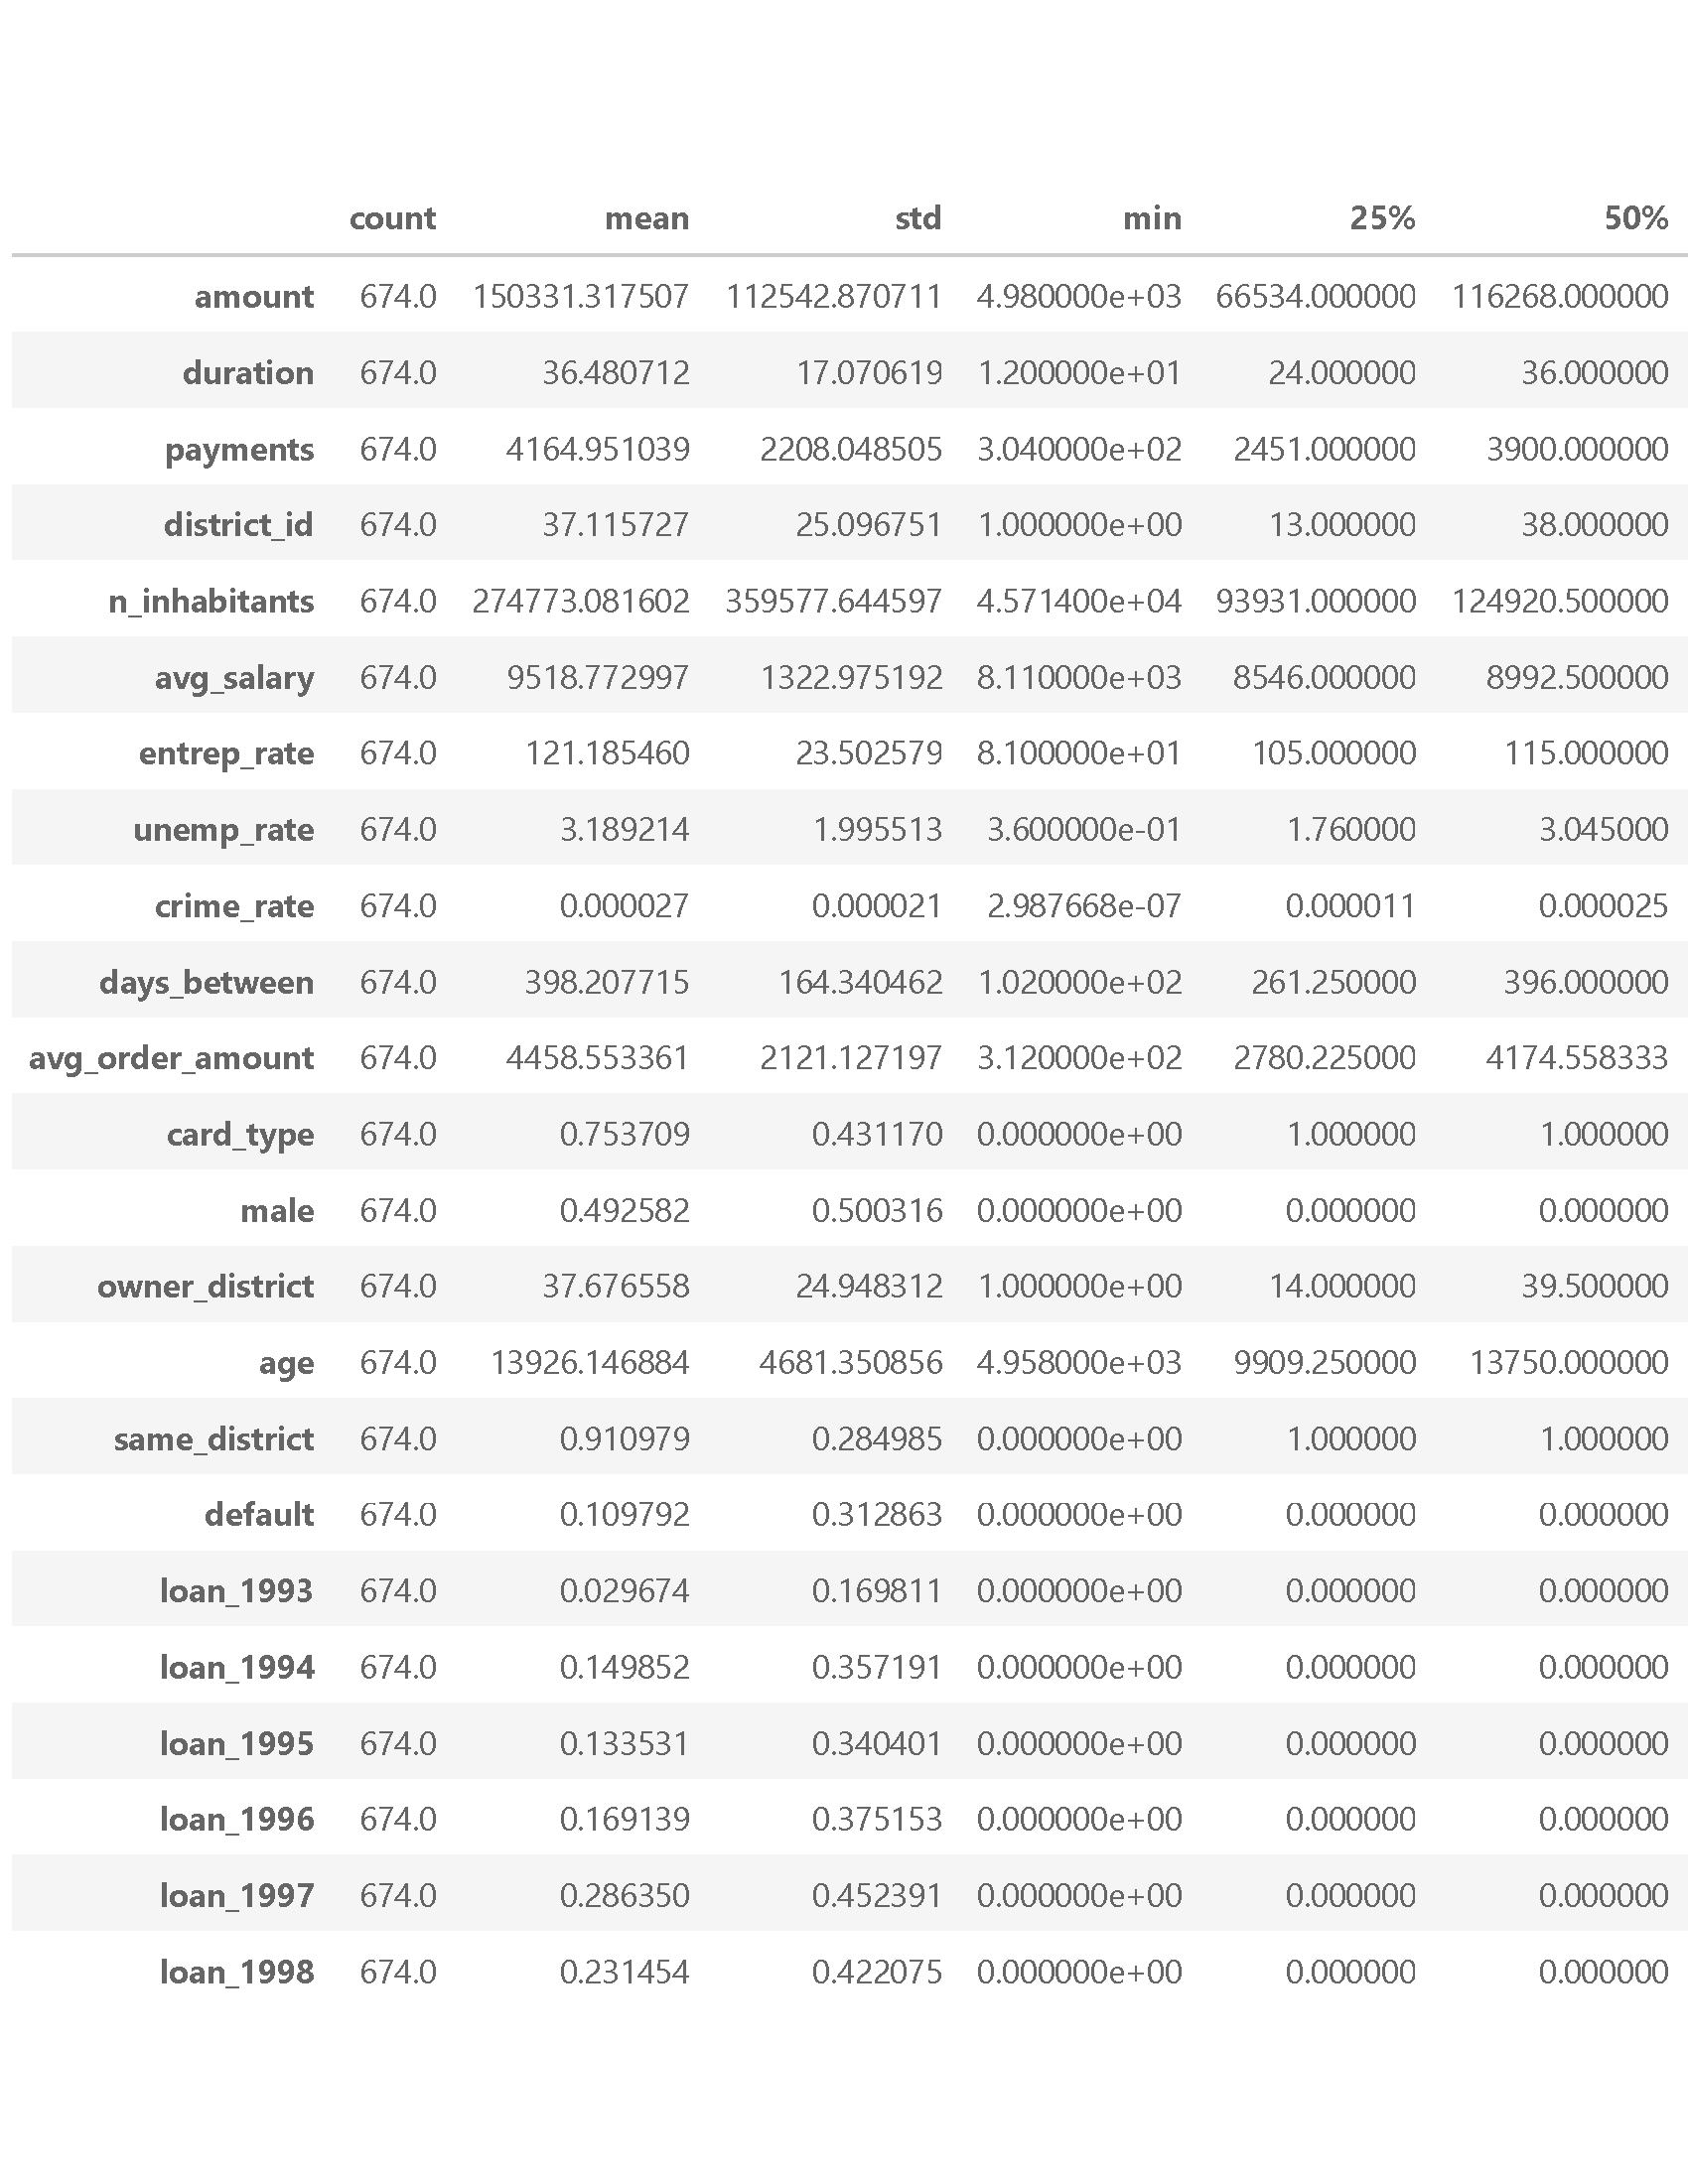

# 3. Exploratory Data Analysis

## 3.1 Compare Loan Amount and Default Status

* Create a histogram of loan amount for loans in good standing.
* Create a histogram of loan amount for loans in default standing.
* Put them side-by-side
* Add commentary.

/Users/prabinadhikari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/prabinadhikari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, -0.2, 'It is found that loan default groups around 200, 400, and 600 days between loan issuance and account creation. Histogram has multiple peaks.')

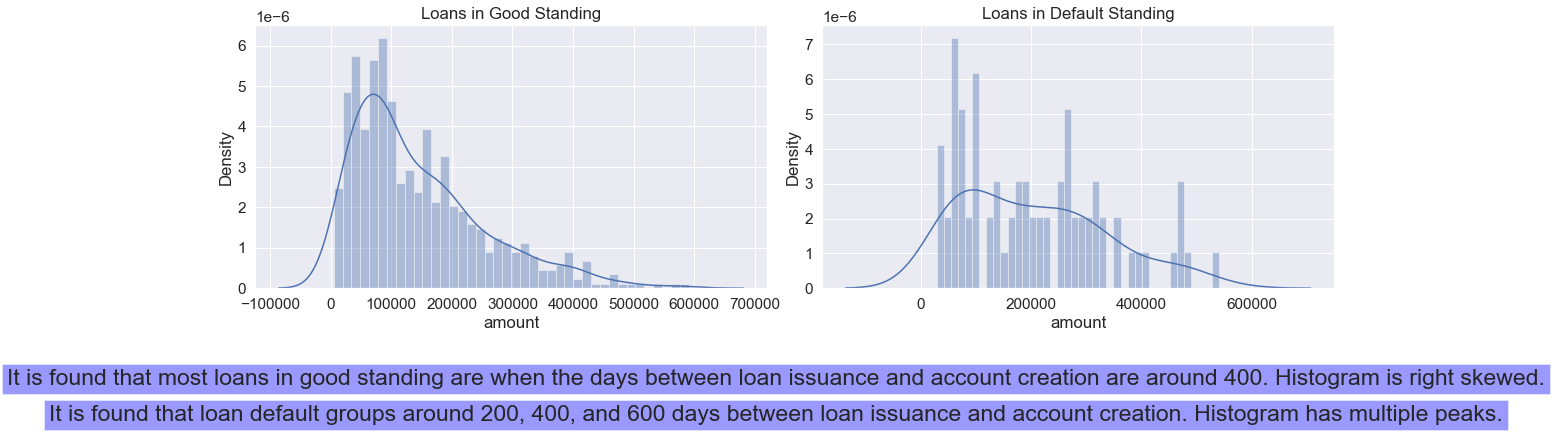

In [130]:
fig, axx = plt.subplots(1, 2, figsize=(16,5))
axx[0].set_title('Loans in Good Standing')
sns.distplot(a=df1[df1['Loan']=='Good']['amount'], ax=axx[0], bins=40)
axx[1].set_title('Loans in Default Standing')
sns.distplot(a=df1[df1['Loan']=='Default']['amount'], ax=axx[1], bins=40)
plt.tight_layout()
plt.figtext(0.5, -0.1, "It is found that most loans in good standing are when the days between loan issuance and account creation are around 400. Histogram is right skewed.", ha="center", fontsize=23, bbox={"facecolor":"blue", "alpha":0.4, "pad":5})
plt.figtext(0.5, -0.2, "It is found that loan default groups around 200, 400, and 600 days between loan issuance and account creation. Histogram has multiple peaks.", ha="center", fontsize=23, bbox={"facecolor":"blue", "alpha":0.4, "pad":5})

## 3.2 Compare `days_between` and Default Status

* Create a histogram of days between loan issuance and account creation for loans in good standing.
* Create a histogram of days between loan issuance and account creation for loans in default standing.
* Put them side-by-side.
* Add commentary.

/Users/prabinadhikari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/prabinadhikari/opt/anaconda3/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, -0.2, 'Histogram for days between loan issuance and account creation for loans in default standing seems to be normally distributed.')

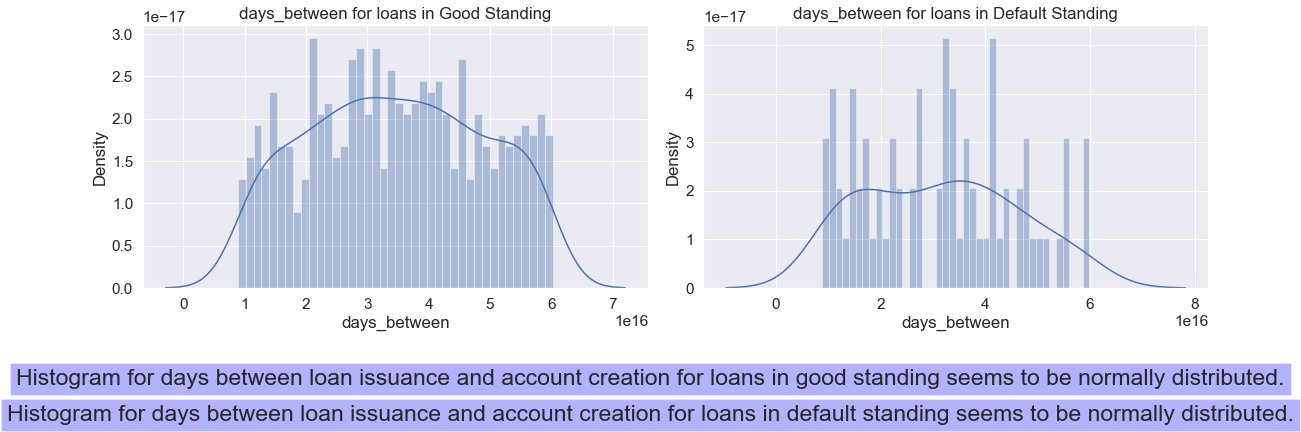

In [132]:
fig, axx = plt.subplots(1, 2, figsize=(16,5))
axx[0].set_title('days_between for loans in Good Standing')
sns.distplot(a=df1[df1['Loan']=='Good']['days_between'], ax=axx[0], bins=40)
axx[1].set_title('days_between for loans in Default Standing')
sns.distplot(a=df1[df1['Loan']=='Default']['days_between'], ax=axx[1], bins=40)
plt.tight_layout()
plt.figtext(0.5, -0.1, "Histogram for days between loan issuance and account creation for loans in good standing seems to be normally distributed.", ha="center", fontsize=23, bbox={"facecolor":"blue", "alpha":0.3, "pad":6})
plt.figtext(0.5, -0.2, "Histogram for days between loan issuance and account creation for loans in default standing seems to be normally distributed.", ha="center", fontsize=23, bbox={"facecolor":"blue", "alpha":0.3, "pad":6})

# 4. Model Development 

This is a binary classification problem so let's try using a Random Forest model to predict loan default.

### 4.1 Separate the Data into Training and Testing Sets

Set the `random_state=10` for comparability.

In [133]:
from sklearn.model_selection import train_test_split

X=df3.drop(['Loan'], axis = 1)  # Features
y=df3['Loan']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state = 10) # 70% training and 30% test

### 4.2 Scale the Training and Testing Data

In [134]:
from sklearn.preprocessing import MinMaxScaler

y = df3['Loan']
df3 = df3.drop(['Loan'], axis=1)  

scaler = MinMaxScaler() #normalize the data 
scaled_train = scaler.fit_transform(dff)
scaled_train = pd.DataFrame(scaled_train, 
                            columns=dff.columns, index=dff.index)

scaled_train.head()

amount  duration  payments  days_between  Average Amount_x  \
3   0.193237      0.50  0.273703      0.129534          0.490836   
4   0.543262      1.00  0.444572      0.162349          0.488549   
9   0.216484      0.25  0.475516      0.046632          0.481287   
33  0.081129      0.25  0.191915      0.493955          0.194231   
38  0.320239      1.00  0.257658      0.388601          0.260775   

    Total Transactions  Number of Inhabitants  Average Salary  \
3             0.695286               0.055974        0.133013   
4             0.878788               1.000000        1.000000   
9             0.607744               0.116050        0.428571   
33            0.759259               0.241839        0.572344   
38            0.654882               0.088516        0.084936   

    Average Unemployment Rate  Entrepreneuer Rate  Average Crime Rate  Gender  \
3                    0.432553            0.651163            0.292129     1.0   
4                    0.000000            1.000000            1.000000     0.0   
9                    0.142698            0.627907            0.285563     0.0   
33                   0.558528            0.220930            0.609374     1.0   
38                   0.159420            0.325581            0.049346     1.0   

    Owners Age  Same_Dist  Card_Junior  Card_Classic  Monthly  Weekly  
3     0.840445        0.0          0.0           1.0      1.0     0.0  
4     0.017362        0.0          1.0           0.0      0.0     1.0  
9     0.943676        1.0          0.0           1.0      1.0     0.0  
33    0.256371        1.0          0.0           1.0      1.0     0.0  
38    0.215526        1.0          0.0           1.0      1.0     0.0

### 4.3. Fit a Random Forest model to the (scaled) training data. 

Set `n_estimators` to 100.

In [135]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100,random_state=10)

#Train the model
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

### 4.4 Use the Testing Data to Evaluate the Model Accuracy.

In [136]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print('The accuracy of the Random Forest is {0:4.2f}.'.format(metrics.accuracy_score(y_test, y_pred)))

The accuracy of the Random Forest is 0.98.


### 4.5 Evaluate the Fit Using a `confusion_matrix`

Comment on the results of your final model in the report.

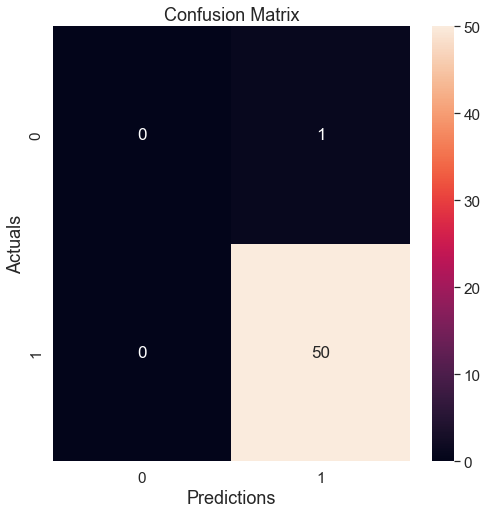

In [139]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(8,8))

sns.set(font_scale=1.4) # for label size
sns.heatmap(cm, ax=ax,annot=True, annot_kws={"size": 17}) # font size

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

### 4.6. Visualize feature importance. Are there any features (variables) we can exclude?

In [140]:
feature_imp = pd.Series(clf.feature_importances_,index=['amount', 'duration', 'payments', 
                                                        'days_between', 
                                                        'Average Amount_x',
                                                        'Total Transactions_x', 
                                                        "Number of Inhabitants", 
                                                        'Average Salary',
                                                        'Average Unemployment Rate', 
                                                        'Entrepreneuer Rate', 
                                                        'Average Crime Rate',
                                                        'Gender', 'Owners_Age', 
                                                        'Same_District', 'Junior', 
                                                        'Classic',
                                                        'Montly', 
                                                        'Weekly']).sort_values(ascending=False)


feature_imp

Owners_Age                   0.169550
amount                       0.115602
Average Unemployment Rate    0.096193
Average Salary               0.089699
Total Transactions_x         0.086342
payments                     0.070105
Average Amount_x             0.067788
days_between                 0.055193
duration                     0.052313
Average Crime Rate           0.048212
Entrepreneuer Rate           0.043452
Number of Inhabitants        0.034856
Same_District                0.033746
Gender                       0.022965
Junior                       0.008494
Classic                      0.005328
Montly                       0.000161
Weekly                       0.000000
dtype: float64

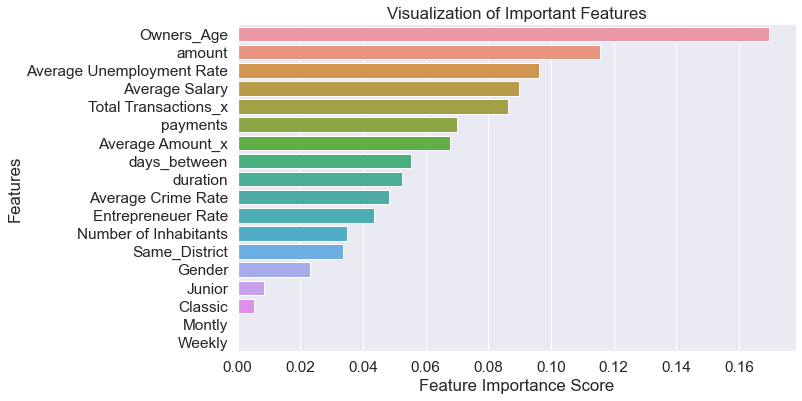

In [141]:
fig, ax = plt.subplots(figsize=(10,6))

sns.barplot(x=feature_imp, y=feature_imp.index,ax=ax)

plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualization of Important Features")
sns.despine()

plt.show()

### 4.7 Improve the Model. 

* Remove less important features. Your choice.<br><br>
* Use a different `n_estimator` value when fitting the Random Forest. Try looping through different values and plot the accuracy scores achieved across fitted models.<br><br>NB, There's a subtle point here that random forest models are thought to not require cross-validation because they inherently do it inside the algorithm to construct the best model. That said, we can still tune the model as demonstrated here. It's just that we don't have to be explicit about the k-folds.

In [149]:
df4 = df3[['Owners_Age', 'amount', 'Average Unemployment Rate', 
           'Total Transactions_x', 'Average Salary', 'payments', 'Average Amount_x']]
df4.head(10)

Owners_Age  amount  Average Unemployment Rate  Total Transactions_x  \
3    53.287884  105804                       4.31                   462   
4    14.998255  274740                       0.43                   571   
9    58.090173  117024                       1.71                   410   
33   26.116895   51696                       5.44                   500   
38   24.216787  167100                       1.86                   438   
40   36.551059   65184                       1.96                   464   
46   18.283743   80340                       0.59                   423   
51   34.013019   25944                       4.48                   357   
54   41.079557  151560                       4.12                   421   
55   34.883673   52128                       3.67                   526   

    Average Salary  payments  Average Amount_x  
3             8754    2939.0       4966.350000  
4            12541    4579.0       4944.666667  
9            10045    4876.0       4875.800000  
33           10673    2154.0       2153.800000  
38            8544    2785.0       2784.800000  
40            9897    5432.0       5432.300000  
46            9622    6695.0       6695.000000  
51            9832    1081.0       1081.000000  
54            8512    6315.0       8224.500000  
55            9650    2172.0       2172.000000

In [150]:
from sklearn.model_selection import train_test_split

X=df4  # Features

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state = 10) # 70% training and 30% test

ValueError: Found input variables with inconsistent numbers of samples: [170, 12]

In [144]:
scaler = MinMaxScaler() #normalize the data to one scale like we did in GEP risk score calculation
scaled_train = scaler.fit_transform(df4)
scaled_train = pd.DataFrame(scaled_train, columns=df4.columns, index=df4.index)

scaled_train.head()

Owners_Age    amount  Average Unemployment Rate  Total Transactions_x  \
3     0.840445  0.193237                   0.432553              0.695286   
4     0.017362  0.543262                   0.000000              0.878788   
9     0.943676  0.216484                   0.142698              0.607744   
33    0.256371  0.081129                   0.558528              0.759259   
38    0.215526  0.320239                   0.159420              0.654882   

    Average Salary  
3         0.133013  
4         1.000000  
9         0.428571  
33        0.572344  
38        0.084936

In [145]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=150,random_state=10)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

The accuracy of the Random Forest is 0.96 when n_estimators = 1
The accuracy of the Random Forest is 0.88 when n_estimators = 2
The accuracy of the Random Forest is 0.98 when n_estimators = 3
The accuracy of the Random Forest is 0.98 when n_estimators = 5
The accuracy of the Random Forest is 0.98 when n_estimators = 20
The accuracy of the Random Forest is 0.98 when n_estimators = 40
The accuracy of the Random Forest is 0.98 when n_estimators = 60
The accuracy of the Random Forest is 0.98 when n_estimators = 80
The accuracy of the Random Forest is 0.98 when n_estimators = 100
The accuracy of the Random Forest is 0.98 when n_estimators = 150
The accuracy of the Random Forest is 0.98 when n_estimators = 200
The accuracy of the Random Forest is 0.98 when n_estimators = 500


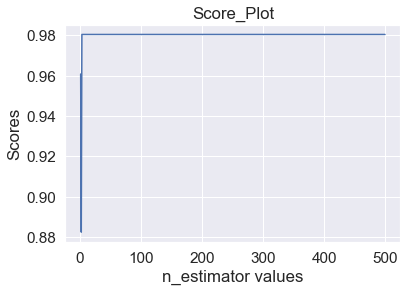

In [148]:
data = []

for x in [1, 2, 3, 5, 20, 40, 60, 80, 100, 150, 200, 500]:
    clf=RandomForestClassifier(n_estimators=x,random_state=0)
    clf.fit(X_train,y_train)
    y_pred=clf.predict(X_test)
    print('The accuracy of the Random Forest is {0:4.2f}'.
          format(metrics.accuracy_score(y_test, y_pred)) + ' when n_estimators = ' + str(x))
    data.append(metrics.accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
  
x = [1, 2, 3, 5, 20, 40, 60, 80, 100, 150, 200, 500]
y = data
  
plt.plot(x, y)
plt.xlabel('n_estimator values')
plt.ylabel('Scores')
  
plt.title('Score_Plot')
  
plt.show()